In [1]:
import pandas as pd
import numpy as np
import graphviz
import seaborn as sns
import subprocess
from os import system
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, f1_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from IPython.display import Image

1 (+1). Загрузить titanic.csv. Нарисовать диаграммы (гистограммы/круговые/...), по которым можно будет сравнить 1) вероятность выжить для мужчин и женщин, 2) вероятность выжить для пассажиров разных социально-экономических классов (Pclass), 3) стоимость билета в зависимости от социально-экономического класса. Написать, что вам удалось узнать из этих диаграмм (например, «для пассажира 1 класса вероятность выжить составила XX% и оказалась выше, чем у пассажира 2 класса (YY%)»; чем больше информации вы сможете извлечь из диаграмм, тем лучше)

In [2]:
titanic = pd.read_csv('titanic.csv', sep=',')

In [3]:
df = pd.DataFrame(titanic, columns=['Fare', 'Sex', 'Pclass', 'Survived'])

In [4]:
df.head()

,Fare,Sex,Pclass,Survived
0,7.2500,male,3,0
1,71.2833,female,1,1
2,7.9250,female,3,1
3,53.1000,female,1,1
4,8.0500,male,3,0


Преобразовываем в таблицу с данными по количеству выживших/не выживших человек определенного пола.

In [5]:
sex= titanic.groupby(['Sex', 'Survived']).size().unstack()
sex

Survived,0,1
Sex,,
female,81,233
male,468,109


In [6]:
pclass = titanic.groupby(['Pclass', 'Survived']).size().unstack()
pclass

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


In [7]:
sex_prob = (1. * sex.T / sex.T.sum()).T

plt.subplot(121)
plt.title(u'Probability of male and female survival')
plt.bar([0, 1], sex_prob[0], color='#f4a941', label='Died')
plt.bar([0, 1], sex_prob[1], bottom=sex_prob[0], color='#42f492', label='Survived')
plt.xticks([0.5, 1.5], ['female', 'male'], rotation='horizontal')
plt.legend(loc='upper left')

In [8]:
pclass_prob = (1. * pclass.T / pclass.T.sum()).T
pclass_prob

Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363


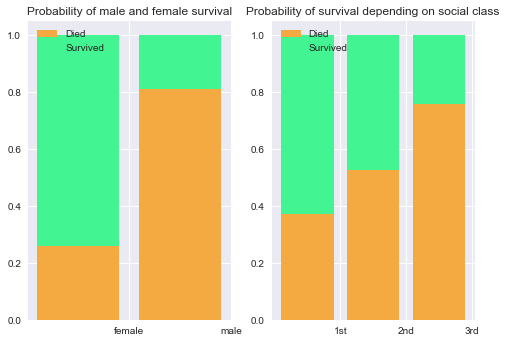

In [9]:
plt.subplot(122)
plt.title(u'Probability of survival depending on social class')
plt.bar([0, 1, 2], pclass_prob[0], color='#f4a941', label='Died')
plt.bar([0, 1, 2], pclass_prob[1], bottom=pclass_prob[0], color='#42f492', label='Survived')
plt.xticks([0.5, 1.5, 2.5], ['1st', '2nd', '3rd'], rotation='horizontal')
plt.legend(loc='upper left')
plt.show()

In [10]:
titanic.fare = titanic['Fare']
titanic.pclass = titanic['Pclass']
titanic.sex = titanic['Sex']

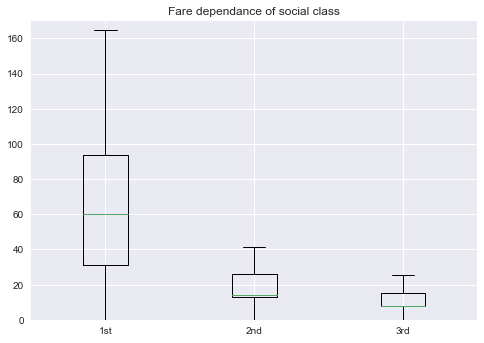

In [11]:
first_class = titanic.fare[titanic.pclass == 1]
second_class = titanic.fare[titanic.pclass == 2]
third_class = titanic.fare[titanic.pclass == 3]

plt.title(u'Fare dependance of social class')
plt.boxplot([first_class, second_class, third_class])
plt.xticks([1, 2, 3], ["1st", "2nd", "3rd"])
plt.ylim(0, 170)

plt.show()


2 (+2). А теперь нарисуем два предиктора на одной диаграмме. Нарисовать гистограмму, описывающую среднюю вероятность выжить в зависимости от пола и соц. статуса. Например, это может быть гистограмма с тремя группами столбцов (разделение по соц.статусу), в которой высота столбца соответствует среднему числу выживших, а цвет столбца обозначает пол пассажиров. Снова интерпретировать результаты (Например, какова вероятность выжить женщине из первого класса?). Записать любые два утверждения в виде формул (нужно вспомнить, что такое совместная и/или условная вероятность).


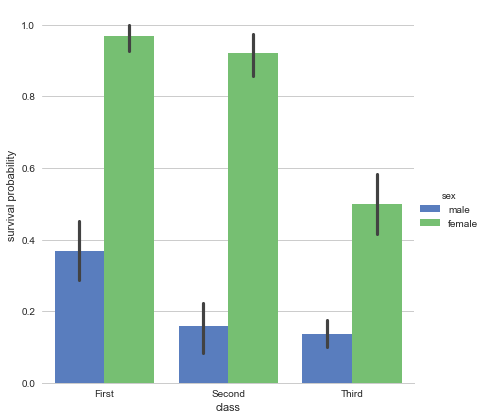

In [12]:
sns.set(style="whitegrid")
titanic_sns = sns.load_dataset("titanic")
g = sns.factorplot(x="class", y="survived", hue="sex", data=titanic_sns,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")
plt.show()

3 (+2). Почистите данные так, как считаете нужным (не забывайте про коварную переменную Sex; постарайтесь не удалять строки). Extra: сможете ли вы использовать не 4 столбца, а больше? Например, кажется, что если ребёнок ехал с братом/сестрой, то их не разлучат, а посадят вместе в шлюпку, и они выживут...

In [13]:
df = pd.DataFrame(titanic, columns=['Fare', 'Age', 'Sex', 'Pclass', 'SibSp', 'Parch', 'Survived'])

In [14]:
df['Sex'] = df['Sex'].map({'female': 0, 'male':1}).astype(int)
df.head()

,Fare,Age,Sex,Pclass,SibSp,Parch,Survived
0,7.2500,22.0,1,3,1,0,0
1,71.2833,38.0,0,1,1,0,1
2,7.9250,26.0,0,3,0,0,1
3,53.1000,35.0,0,1,1,0,1
4,8.0500,35.0,1,3,0,0,0


In [15]:
df.fillna(df['Age'].median(skipna=True), inplace=True)
df.head()

,Fare,Age,Sex,Pclass,SibSp,Parch,Survived
0,7.2500,22.0,1,3,1,0,0
1,71.2833,38.0,0,1,1,0,1
2,7.9250,26.0,0,3,0,0,1
3,53.1000,35.0,0,1,1,0,1
4,8.0500,35.0,1,3,0,0,0


4 (+2). Разделить данные на обучающую и проверочную выборки (или использовать кросс-валидацию).

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 0:5], df['Survived'], random_state=42)
X_train.head()

,Fare,Age,Sex,Pclass,SibSp
298,30.5000,28.00,1,1,0
884,7.0500,25.00,1,3,0
247,14.5000,24.00,0,2,0
478,7.5208,22.00,1,3,0
305,151.5500,0.92,1,1,1


Будем строить дерево решений. Нужно выбрать параметр модели, который, на ваш взгляд, может повлиять на результат, и выбрать для него возможные значения.

Extra: варьировать не в цикле, а использовать grid search.

In [52]:
clf = DecisionTreeClassifier(random_state=42)

In [53]:
scores = cross_val_score(clf, X_train, y_train, cv=10)
np.mean(scores)

0.76371351797163911

Прокомментировать свой выбор.

In [54]:
parameters = {
              #'max_features':[None, 'auto', 'sqrt', 'log2'], 
              'max_depth':[None, 3, 4, 5, 6, 10],
              'max_leaf_nodes':[None, 6, 8, 10, 12, 14],
              'min_samples_leaf': [3, 5, 7, 10],
              #'presort': [True, False],
              #'min_weight_fraction_leaf':[0, .3, .5],
              #'criterion':['gini', 'entropy'],
              #'splitter':['best', 'random']
             }
gs = GridSearchCV(clf, parameters)

In [55]:
gs.fit(np.array(X_train), np.array(y_train))

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [None, 3, 4, 5, 6, 10], 'max_leaf_nodes': [None, 6, 8, 10, 12, 14], 'min_samples_leaf': [3, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Изменяя в цикле значения параметра, посчитать для каждого случая точноть, полноту, F-меру (может быть, другие метрики?). 

In [56]:
y_pred = gs.predict(np.array(X_test))

In [77]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.80      0.92      0.86       134
          1       0.84      0.66      0.74        89

avg / total       0.82      0.82      0.81       223



Изобразить результаты на диаграмме/-ах. Интерпретировать результаты. 

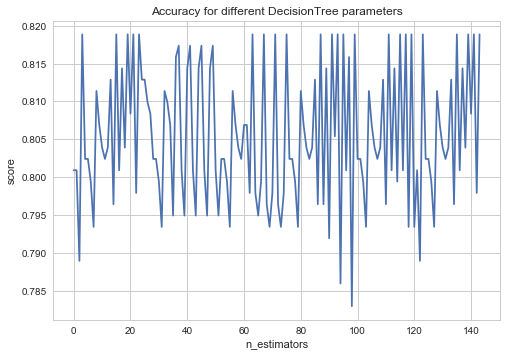

In [58]:
plt.plot(gs.cv_results_['mean_test_score'])
plt.title('Accuracy for different DecisionTree parameters')
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show()

In [59]:
gs.best_params_

{'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 10}

In [69]:
gs.best_score_

0.83083832335329344

Нарисовать лучшее дерево.

In [61]:
clf = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=10, min_samples_leaf=7, random_state=42)
clf = clf.fit(np.array(X_train), np.array(y_train))
features = list(df.columns[:6])
export_graphviz(clf, out_file="tree.dot", feature_names=features)
# with open("mytree.dot") as f:
#     dot_graph = f.read()
# graphviz.Source(dot_graph)

Super–duper-Extra: построить ROC-кривую и написать свою интерпретацию того, что эта диаграмма говорит о модели.

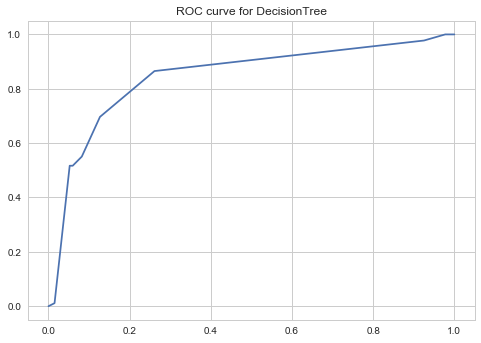

In [62]:
probas_ = clf.fit(np.array(X_train), np.array(y_train)).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
plt.title('ROC curve for DecisionTree')
plt.plot(fpr, tpr)
plt.show()

5 (+2). Проделать аналогичные операции для модели Random Forest.

In [64]:
clf = RandomForestClassifier(random_state=42)

In [65]:
scores = cross_val_score(clf, X_train, y_train, cv=10)
np.mean(scores)

0.81732048314576855

In [66]:
parameters = {
              'n_estimators': [65, 70, 75],
              #'criterion': ['gini', 'entropy'],
              #'max_features':[None, 'auto', 'sqrt', 'log2'], 
              'max_depth':[None, 6, 8, 10, 12],
              'max_leaf_nodes':[None, 6, 8, 10, 12],
              'min_samples_leaf': [2, 3, 4],
              #'min_weight_fraction_leaf':[0, .3, .5]
             }

In [67]:
gs = GridSearchCV(clf, parameters)

In [68]:
gs.fit(np.array(X_train), np.array(y_train))

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [65, 70, 75], 'max_depth': [None, 6, 8, 10, 12], 'max_leaf_nodes': [None, 6, 8, 10, 12], 'min_samples_leaf': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [70]:
y_pred = gs.predict(np.array(X_test))

In [71]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.80      0.92      0.86       134
          1       0.84      0.66      0.74        89

avg / total       0.82      0.82      0.81       223



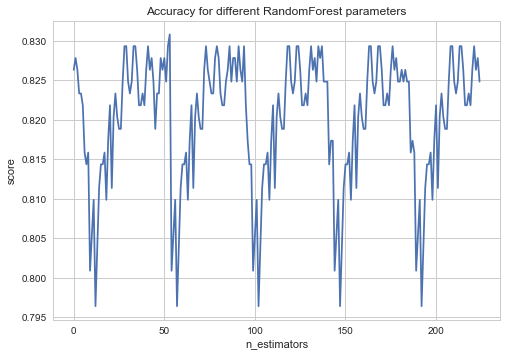

In [72]:
plt.plot(gs.cv_results_['mean_test_score'])
plt.title('Accuracy for different RandomForest parameters')
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show()

In [73]:
gs.best_params_

{'max_depth': 6,
 'max_leaf_nodes': None,
 'min_samples_leaf': 4,
 'n_estimators': 75}

In [74]:
gs.best_score_

0.83083832335329344

In [75]:
probas_ = gs.fit(np.array(X_train), np.array(y_train)).predict_proba(X_test)

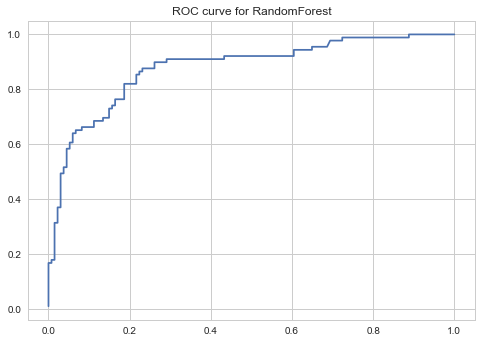

In [76]:
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
plt.title('ROC curve for RandomForest')
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.show()

Сравнить результаты.